# Malaria Bounding Boxes

Dataset courtesy - https://www.kaggle.com/kmader/malaria-bounding-boxes

## Context

Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.

Previous attempts to automate the process of identifying and quantifying malaria have not gained major traction partly due to difficulty of replication, comparison, and extension. Authors also rarely make their image sets available, which precludes replication of results and assessment of potential improvements. The lack of a standard set of images nor standard set of metrics used to report results has impeded the field.

#### Courtesy - https://www.kaggle.com/kmader/malaria-bounding-boxes

## Content

Images are in .png or .jpg format. There are 3 sets of images consisting of 1364 images (~80,000 cells) with different researchers having prepared each one: from Brazil (Stefanie Lopes), from Southeast Asia (Benoit Malleret), and time course (Gabriel Rangel). Blood smears were stained with Giemsa reagent.

Labels
The data consists of two classes of uninfected cells (RBCs and leukocytes) and four classes of infected cells (gametocytes, rings, trophozoites, and schizonts). Annotators were permitted to mark some cells as difficult if not clearly in one of the cell classes. The data had a heavy imbalance towards uninfected RBCs versus uninfected leukocytes and infected cells, making up over 95% of all cells.

A class label and set of bounding box coordinates were given for each cell. For all data sets, infected cells were given a class label by Stefanie Lopes, malaria researcher at the Dr. Heitor Vieira Dourado Tropical Medicine Foundation hospital, indicating stage of development or marked as difficult.

#### Courtesy - https://www.kaggle.com/kmader/malaria-bounding-boxes

## Problem statement

This is an object detection problem wherein given a test image the algorithm has to determine the following:
1. The objects/cells present in the images of the blood smears
2. A class label along with the class probability assigned to each of the objects/cells detected in the image
3. The location, determined by the bounding box coordinates, for each of the objects detected 

## Exploratory Data Analysis

### 1. Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import os
import json
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns

### 2. File loading

In [2]:
#Checking is the directory of the json files and the images is correct
data_subdir ='data/malaria'
abs_path= os.path.abspath(os.getcwd() +'/..')
data_dir= os.path.join(abs_path,data_subdir)
if os.path.isdir(data_dir):
    print('The directory path is valid')

The directory path is valid


In [3]:
#Checking the directory structure
for dirpath,dirnames,_ in os.walk(data_dir):
    print(f"The dir path is --{dirpath.replace(abs_path,'')} and the dir name is --{dirnames}")

The dir path is --/data/malaria and the dir name is --['images']
The dir path is --/data/malaria/images and the dir name is --[]


In [4]:
#Loading the training.json file
with open(os.path.join(data_dir,'training.json'),'r') as f:
    train_data= json.load(f)

In [5]:
print(f"The number of images in the train data are {len(train_data)}")

The number of images in the train data are 1208


In [6]:
#Checking a datapoint
train_data[9]

{'image': {'checksum': '8b5cb906538df0f49df5e72efef40eaa',
  'pathname': '/images/bbf687b5-c6f9-4821-b2e5-a25df1acba47.png',
  'shape': {'r': 1200, 'c': 1600, 'channels': 3}},
 'objects': [{'bounding_box': {'minimum': {'r': 971, 'c': 1066},
    'maximum': {'r': 1095, 'c': 1189}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 1079, 'c': 847},
    'maximum': {'r': 1191, 'c': 969}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 110, 'c': 806},
    'maximum': {'r': 235, 'c': 958}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 316, 'c': 771},
    'maximum': {'r': 432, 'c': 929}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 21, 'c': 1061},
    'maximum': {'r': 146, 'c': 1191}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 798, 'c': 1392},
    'maximum': {'r': 927, 'c': 1531}},
   'category': 'red blood cell'},
  {'bounding_box': {'minimum': {'r': 703, 'c': 377},
  

### 3. Descriptive statistics

In [7]:
no_images = sum([len(i['objects']) for i in train_data])
print('The total number of infectious/non-infectious cells in the training data are {}'.format(no_images))

The total number of infectious/non-infectious cells in the training data are 80113


In [9]:
min_images = min([len(i['objects']) for i in train_data])
print('The minimum number of infectious/non-infectious cells in an image in the training data is {}'.format(min_images))

The minimum number of infectious/non-infectious cells in an image in the training data is 9


In [10]:
max_images = max([len(i['objects']) for i in train_data])
print('The maximum number of infectious/non-infectious cells in an image in the training data is {}'.format(max_images))

The maximum number of infectious/non-infectious cells in an image in the training data is 223


In [11]:
med_images= np.median([len(i['objects']) for i in train_data])
print('The median of the number of infectious/non-infectious cells in the training data is {}'.format(med_images))

The median of the number of infectious/non-infectious cells in the training data is 59.0


In [12]:
avg_images= np.mean([len(i['objects']) for i in train_data])
print('The average number of infectious/non-infectious cells in the training data is {}'.format(avg_images))

The average number of infectious/non-infectious cells in the training data is 66.31870860927152


In [13]:
mode_images= stats.mode([len(i['objects']) for i in train_data])
print('The mode of infectious/non-infectious cells in the training data is {}'.format(mode_images[0][0]))

The mode of infectious/non-infectious cells in the training data is 58


### 4. Additional analysis

#### Following is the top number of cells that can be found in an image along with their frequency

In [14]:
Counter([len(i['objects']) for i in train_data]).most_common()[:10]

[(58, 25),
 (57, 24),
 (67, 23),
 (53, 22),
 (59, 22),
 (43, 21),
 (45, 21),
 (51, 21),
 (55, 20),
 (64, 20)]

#### Following is the PDF of the number of cells in an image

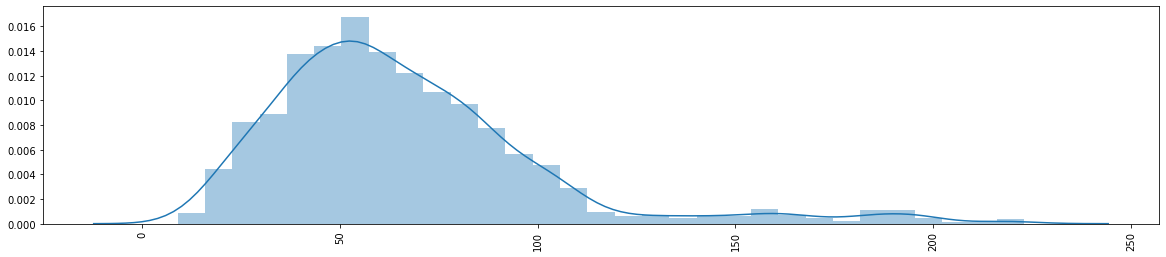

In [15]:
plt.figure(figsize=(20,4))
sns.distplot([len(i['objects']) for i in train_data])
plt.xticks(rotation =90)
plt.show()

#### Following is the cell names and their frequencies in the training data. It can be seen that the data is heavily imbalanced

In [17]:
celltype_count= dict(Counter([cell['category'] for image in train_data for cell in image['objects']]))
celltype_count

{'red blood cell': 77420,
 'trophozoite': 1473,
 'schizont': 179,
 'difficult': 441,
 'ring': 353,
 'leukocyte': 103,
 'gametocyte': 144}

#### Plotting the information displayed above as percentages below. It can be seen from the following graph that ~97% of the cells are Red Blood Cells , ~1 % Trophozite, ~0.5% Difficult and Ring each 

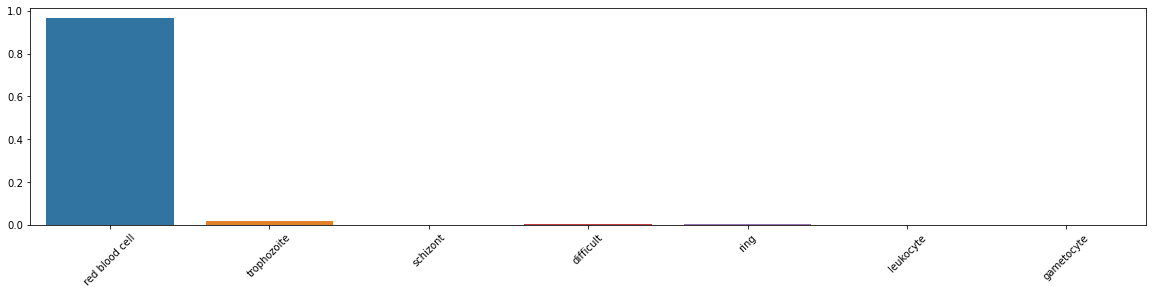

In [18]:
plt.figure(figsize=(20,4))
sns.barplot(list(celltype_count.keys()),[i/no_images for i in list(celltype_count.values())])
plt.xticks(rotation =45)
plt.show()

In [20]:
#Getting an idea of the cells present in a few of the images
cell_counts_per_image= [dict(Counter([cell['category'] for cell in image['objects']])) for image in train_data]
cell_counts_per_image[:10]

[{'red blood cell': 71, 'trophozoite': 3},
 {'red blood cell': 61},
 {'red blood cell': 18, 'schizont': 1, 'difficult': 1},
 {'red blood cell': 41, 'ring': 1},
 {'red blood cell': 45, 'difficult': 2, 'schizont': 1, 'leukocyte': 1},
 {'red blood cell': 84, 'trophozoite': 8},
 {'red blood cell': 46, 'ring': 2},
 {'red blood cell': 56, 'difficult': 2},
 {'red blood cell': 17, 'gametocyte': 1},
 {'red blood cell': 8, 'gametocyte': 1}]

In [21]:
print('The total no of images are {}'.format(len(cell_counts_per_image)))

The total no of images are 1208


#### Getting the cell information for each of the images in the following step

In [22]:
cell_counts_per_image= pd.DataFrame(cell_counts_per_image).fillna(0).astype(int)
cell_counts_per_image.head()

,red blood cell,trophozoite,schizont,difficult,ring,leukocyte,gametocyte
0,71,3,0,0,0,0,0
1,61,0,0,0,0,0,0
2,18,0,1,1,0,0,0
3,41,0,0,0,1,0,0
4,45,0,1,2,0,1,0


#### Following are the details of the number of images which have infectious/non-infectious cells. It can be seen that red blood cells are present in all the cells

In [23]:
print('The no of images which have the following cells:')
np.sum(cell_counts_per_image != 0,axis=0)

The no of images which have the following cells:


red blood cell    1208
trophozoite        596
schizont           157
difficult          342
ring               244
leukocyte           94
gametocyte         136
dtype: int64

In [24]:
print('The percentage of images that have the following cells:')
np.round((np.sum(cell_counts_per_image != 0,axis=0)/len(cell_counts_per_image))*100,3)

The percentage of images that have the following cells:


red blood cell    100.000
trophozoite        49.338
schizont           12.997
difficult          28.311
ring               20.199
leukocyte           7.781
gametocyte         11.258
dtype: float64

#### Following is the method to draw out the images and the bounding boxes for the cells

In [25]:
def draw_image(ind):
    path= os.path.join(data_dir,train_data[ind]['image']['pathname'].lstrip('/'))
    
    if os.path.isfile(path):
        plt.figure(figsize=(25,7))
        min_list=  list(map(lambda x: (x['bounding_box']['minimum']['c'],x['bounding_box']['minimum']['r']), train_data[ind]['objects']))
        max_list=  list(map(lambda x: (x['bounding_box']['maximum']['c'],x['bounding_box']['maximum']['r']), train_data[ind]['objects']))
        cats= [i['category'] for i in train_data[ind]['objects']]
        
        image= cv2.imread(path)
        for i, j, k in zip(min_list,max_list,cats):
            cv2.rectangle(image,i,j,(0, 0, 0) ,2)
            cv2.putText(image,k,(i[0],i[1]-5),cv2.FONT_HERSHEY_COMPLEX,.8,(0,0,0),2)
            
        img2 = image[:,:,::-1]
        plt.imshow(img2)
    

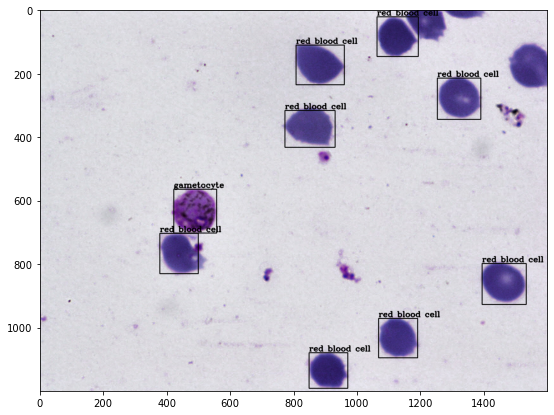

In [26]:
draw_image(9)

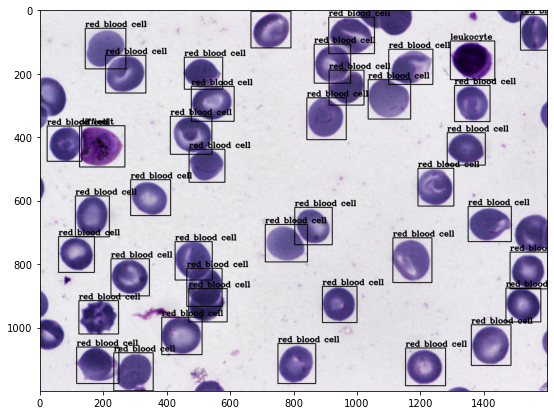

In [27]:
draw_image(234)

## Conclusion

1. There are a total of 1208 images available for training
2. In these there are a total of 80113 cells(infectious/non-infectious)
3. The least and most number of cells present in the images is 9 and 223 respectively
4. The data set is heavily imbalanced towards the RBCs, with the ~97% of the cells being Red Blood Cells , ~1 % Trophozite, ~0.5% Difficult and Ring each
5. Also, all the images have RBC cells, ~50% have Trophozoite and only 7.8% have leucocytes 